# STAC catalog: searching for earth imagery

In this exercise, we explore STAC catalog and provide an introduction earth imagery search. STAC stands for Spatio Temporal Access Catalog.
The workflow is divided in 8 sections:

1. Definining AOI
2. STAC API search and query
3. Accessing data and plotting
4. Writing out data and downloading
5. Conclusions.
6. References


# Using STAC to explore and download COGS data

STAC is a standard developed to facilitate search, exploration and access of earth/remote sensing imagery. The main goal is to provide a unified sets of descriptions along with sofware packages to quickly locate useful imagery by the users. Providers and distributors of imagery follow to standard to make their data easily accessible and searchable.

STAC is implement using a series of json object files that provides a description of datasets from providers.

# COGS

COG (Cloud Optimized Geotiff) is tightly linked to STAC because it allows part or chunks of data described by STAC more easibly accessible.

# STAC package: pystac

This is the standard package that can be used to search and explore a STAC catatog.

# AOI: Area of Interest - Vermont Flooding event

To explore STAC, we must define a AOI. For this tutorial, e use Vermont flooding that occured between July 9 and 11, 2023 as an AOI and case study. This flood event had a major impact on the state with 14 counties declared as state disaster. River levels increased across the state and the Winooski River near Montpellier, the state capital, jumped by 14 feet within a 20 hour time period. We define an AOI around Montpellier VT and search for Sentinel 2 imagery around the date of the event.

## Interesting links:

- STAC concepts:

https://medium.com/radiant-earth-insights/spatiotemporal-asset-catalogs-and-the-open-geospatial-consortium-659538dce5c7

- STAC package: pystac

https://pystac.readthedocs.io/en/stable/



# Set up environment and load libraries

- load libraries
- install packages and tools
- authenticate to google drive and gcp account

First let's list a few parameters to understand the computing environment that we are using. In particular:
- os system
- python version
- hostname

In [2]:
!uname -a
!lsb_release -a
!python --version
!hostname
!whoami

Linux 766cd0042734 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy
Python 3.10.12
766cd0042734
root


Let's then install GDAL binaries and spatial libraries necessary for gdal, rasterio and xarray.

In [3]:
#install gdal to run from the terminal
!sudo add-apt-repository ppa:ubuntugis/ppa -y
!sudo apt-get update
!sudo apt-get install gdal-bin
!gdalinfo --version

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu/ jammy main'
Description:
Official stable UbuntuGIS packages.


More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Adding repository.
Found existing deb entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Found existing deb-src entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ppa.gpg with fingerprint 2EC86B48E6A9F326623CD22FFF0E7BBEC491C6A1
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4

Install other geospatial related libraries

In [5]:
#set up libararies for GIS/Geospatial
try: # try the following b+lock of code
  import geopandas as gpd
except: # if the try block throws an error, run the following
  !pip install geopandas # install geopandas
  import geopandas as gpd

try:
  import contextily as ctx # import
  import rasterio
except:
  !pip install fiona
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  !pip install rasterio
import fiona # library for reading/writing GIS files, comes w/ geopandas
from shapely.geometry import Point, LineString, Polygon

!pip install pyproj
# Mapping,vector related imports
import geopandas as gpd
#import descartes #nessary for plotting in geopandas
from cartopy import crs as ccrs
from pyproj import Proj
#from osgeo import osr
from shapely import geometry
from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Polygon

from collections import OrderedDict
#rasterio imports, gdal and imagery utility
import rasterio
from rasterio.windows import Window
from osgeo import gdal
from rasterio import plot
from PIL import Image

#xarray and rio
!pip install rioxarray
!pip install mapclassify
!pip install earthpy

import mapclassify
import folium
import pyproj as proj
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep
from folium.utilities import none_max
import folium
from pyproj import Transformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 24.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libproj-dev is already the newest version (9.1.1-1~jammy0).
proj-bin is already the newest version (9.1.1-1~jammy0).
proj-data is already the newest version (9.1.1-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.11.1-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.1 MB/s eta 0:00:00


General purpose libraries and packages

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import subprocess
import pandas as pd
import os, glob
import zipfile

from pathlib import Path

sns.set_style('darkgrid')
#pd.set_option('display.max_colwidth', None)
!apt install unzip
import urllib
import re
import math
from datetime import datetime
from copy import deepcopy
from numpy.core.multiarray import datetime_as_string
import os
import numpy.ma as ma

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.


In [7]:
#Used in defining functions
from typing import List, Tuple, Dict, Any
from pandas.core.arrays import boolean

Install STAC related libraries

- https://pystac-client.readthedocs.io/_/downloads/en/stable/pdf/
- https://github.com/stac-utils/pystac-client/blob/df034494c2d566f0b2fa6fb8f0455f75d10e0b62/docs/tutorials/aoi-coverage.ipynb


In [8]:
!pip install pystac
#!pystac_client
!pip install pystac-client
!pip install planetary-computer
import planetary_computer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 2.1 MB/s eta 0:00:00


In [9]:
#GCP account authentification
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [10]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Functions
In the next part of the script, we declare all the functions used in the sripts.  It is good practice to place functions at the beginning of a script or in an external source file. Here are the 13 functions used:

In [11]:
def create_dir_and_check_existence(path: str) -> str:
  '''
  Create a new directory

  :param path: path to the directory
  :return: path to the directory
  '''

  try:
    os.makedirs(path)
  except:
    print ("directory already exists")
  return path



In [12]:
def dms_to_dd(val: np.float32) -> np.float32:
  '''
  Convert dms: degree minute second to decimal degree
  Note that the format expect direction with W or S.

  :param val: degree minute second
  :return: decimal degree
  '''

  deg,minute,second,direction = re.split('[°\'\"]', val)
  dd_val = float(deg)+float(minute)/60+float(second)/(60*60)
  if direction == 'W' or direction == 'S':
    dd_val = (-1.)*dd_val
  return dd_val

In [13]:

def bbox_to_poly(bbox: list) -> Polygon:

  '''
  Convert bounding box list into a polygon. With input list xmin,ymin,xmax,ymax.

  :param bbox list: list of coordinates represending a bouding.
  :return: Shapely polygon

  '''

  long0 = bbox[0]
  lat0 = bbox[1]
  long1=bbox[2]
  lat1=bbox[3]

  poly = Polygon([[long0, lat0],
                        [long1,lat0],
                        [long1,lat1],
                        [long0, lat1]])

  return poly

In [14]:
def polygon_from_centroid(x_centroid,y_centroid,size,EPSG_val=4326)-> gpd.GeoDataFrame:

  '''

  Generate a square polygon from center point with a given size and EPSG code
  Return a GeoDataFrame

  :param x_centroid float32: x center of square polygon being created
  :param y_centroid float32: y center of square polygon being created
  :param size float32: length of square polygon
  :param EPSG_val int: EPSG code defining the coordinate system
  :return geopandas geodataframe

  '''

  xmin = x_centroid - size/2
  xmax = x_centroid + size/2
  ymin = y_centroid - size/2
  ymax = y_centroid + size/2

  bbox_list = [xmin,ymin,xmax,ymax]
  bbox_poly = bbox_to_poly(bbox_list)

  bbox_poly_gdf = gpd.GeoDataFrame(pd.DataFrame(['p1'], columns = ['geom']),
         crs = {'init':f'epsg:{EPSG_val}'},
         geometry = [bbox_poly])
  bbox_poly_gdf.to_file('bbox_poly.shp')

  return bbox_poly_gdf

In [15]:
#https://aws.amazon.com/blogs/apn/transforming-geospatial-data-to-cloud-native-frameworks-with-element-84-on-aws/
#https://github.com/stac-utils/pystac-client/blob/1eaf0d97632c411279e8312b337faf842d657474/docs/tutorials/stac-metadata-viz.ipynb
def items_to_geodataframe(items: any) -> gpd.GeoDataFrame:
    '''
    Convert a list of STAC Items into a GeoDataFrame.
    Modified from https://github.com/stac-utils/pystac-client/blob/1eaf0d97632c411279e8312b337faf842d657474/docs/tutorials/stac-metadata-viz.ipynb

    :param items: list of STAC Items
    :return: GeoDataFrame
    '''

    #Using from copy import deepcopy
    _items = []
    for i in items:
        _i = deepcopy(i)
        _i['geometry'] = shape(_i['geometry'])
        _items.append(_i)
    gdf = gpd.GeoDataFrame(pd.json_normalize(_items))
    for field in ['properties.datetime', 'properties.created', 'properties.updated']:
        if field in gdf:
            gdf[field] = pd.to_datetime(gdf[field])
    gdf.set_index('properties.datetime', inplace=True)
    return gdf

In [16]:
from pystac_client import item_search
#https://github.com/stac-utils/pystac-client/blob/1eaf0d97632c411279e8312b337faf842d657474/docs/tutorials/stac-metadata-viz.ipynb
def get_selected_products_and_bands(cat_search: item_search.ItemSearch,
                                    bands_selected: list[str],
                                    platform: str='Sentinel-2A') -> pd.DataFrame:

  '''
  Get the selected products and bands from STAC

  :param items: pystac_client item search object
  :param bands_selected: list of bands to filter
  :return: pandas data frame containing the selected products and bands
  '''

  items_dict = [i.to_dict() for i in cat_search.get_items()]
  print(f"{len(items_dict)} scenes fetched")
  items = items_to_geodataframe(items_dict)
  bands_selected = [f'assets.{b}.href'for b in bands_selected]
  bands_selected
  col_selected = bands_selected + ['collection','id','properties.s2:mgrs_tile','properties.proj:epsg']
  if platform is not None:
    selected_products = items.loc[items['properties.platform']==platform,col_selected] #filter for relevant platform
  else:
    selected_products = items.loc[:,col_selected] #filter for relevant platform

  selected_products = selected_products.reset_index()
  print(selected_products['properties.datetime'].dtypes)
  selected_products['date'] = selected_products['properties.datetime'].dt.date
  selected_products['date'] = selected_products['date'].astype(str)
  list_dates = list(selected_products['date'].unique())
  list_tiles = selected_products['properties.s2:mgrs_tile'].unique()

  return selected_products

In [17]:
#Change the name of the file to include date and better formatting
#Also adjust the resolution
def download_and_reproject_stac_file(date_val:str,
                                     selected_products:pd.DataFrame,
                                     download: bool,
                                     aoi_poly:gpd.GeoDataFrame,
                                     output_epsg: int=None,
                                     output_res: np.float32=None,
                                     out_dir:str='.') -> str:
  '''
  Download and reproject STAC files

  :param date_val: str: date to download and process
  :param selected_products: pd.DataFrame
  :param download: boolean, if true download the raw file without processing
  :param aoi_poly: gpd.GeoDataFrame containing the reference poygon of Area of Interest
  :param output_epsg: int code for EPSG projection coordinate system
  :param output_res: np.float32 resolution of output raster
  :param out_dir: str path to output directory
  :return: output raster file name containing the processed raster
   '''

  bands_cols = list(selected_products.filter(regex='assets').columns)

  for band in bands_cols:
    if download is True:
        raster_file_list = selected_products.loc[selected_products['date']==date_val,band].tolist()
        out_raster_file =[]
        for raster_file in raster_file_list:
           download_path = os.path.join(selected_products.collection)
           in_filename = raster_file
           out_filename = os.path.basename(in_filename.split('?'))[0] #split the name on ?
           os.makedirs(download_path, exist_ok=True)
           out_filename = os.path.join(out_dir,out_filename)
           urllib.request.urlretrieve(in_filename,
                                   out_filename)

           out_raster_file.append(out_filename)

    #crop and project if download is false
    if download is False:

      # Set the AOI cropping
      proj_crs = selected_products.loc[selected_products['date']==date_val,'properties.proj:epsg'].tolist()
      print(proj_crs) #this is the EPSG code
      aoi_poly_proj = aoi_poly.to_crs(f'EPSG:{proj_crs[0]}') #should first extract current EPSG!!
      aoi_poly_proj.to_file('aoi_poly_proj.shp')
      aoi_poly_proj.crs

      #Set the resolution for the ouput
      if output_res is None:
        #if unit is degree we need to call a function
        #if not we use the same res as input
        output_res=0.00009
        #this still needs to be improve
        #use input raster to match the res in the output projection given
      if output_epsg is None:
        crs_val=(aoi_poly.crs.srs)
        epsg_code = crs_val.split(':')[1][:4]
        output_epsg = f'EPSG:{epsg_code}'
      data_val_formatted = date_val.replace("-","")

      download_path = os.path.join(selected_products.collection.unique()[0],
                                    data_val_formatted)
      os.makedirs(download_path, exist_ok=True) # add date

      out_filename=os.path.join(out_dir,
                                download_path, #add date in output path?
                                f'crop_proj_{selected_products2.collection.unique()[0]}_{band}_{data_val_formatted}.tif')
      raster_file_list = selected_products.loc[selected_products['date']==date_val,band].tolist()

      #from pathlib import Path
      out_filename_vrt = Path(out_filename).stem

      raster_file_list_m = [f'/vsicurl/{u}' for u in raster_file_list]

      ds = gdal.BuildVRT( f'{out_filename_vrt}.vrt',
                         raster_file_list_m,
                          VRTNodata=0,
                          srcNodata=0)

      #dstSRS should not be hard coded
      result = gdal.Warp(out_filename,
                          ds,
                          format='GTiff',
                          dstNodata=0,
                          dstSRS= output_epsg, #this should not be hard coded
                          cutlineDSName='aoi_poly_proj.shp',
                          cropToCutline=True,
                          xRes=output_res, #this should not be hard coded
                          yRes=output_res)
      result=None
      out_raster_file = out_filename

  return out_raster_file

In [18]:
#https://gis.stackexchange.com/questions/290796/how-to-edit-the-metadata-for-individual-bands-of-a-multiband-raster-preferably
def update_description_gdal(filepath: str,
                            list_desc: List) -> str:

  '''
  Update the description of a raster file using GDAL

  :param filepath: path/virtual path/uri to raster
  :param list_desc: list of string values for each band description, eg dates
  :return: str stating that the description was updated
  '''

  ds_src = gdal.Open(filepath, gdal.GA_Update)
  i=0
  for desc_val in list_desc:
    i=i+1
    rb = ds_src.GetRasterBand(i)
    rb.SetDescription(desc_val)
  del ds_src
  return "updated descriptions"

In [19]:
## Now set no data and description + recalculate stats after that

def update_nodata_val_raster(in_filename: str,
                             band_val: int=1,
                             nodata_val: int=0) -> str:
  '''
  Update the nodata value of a raster file using GDAL

  :param in_filename: path to raster filep
  :param band_val: band number
  :param nodata_val: nodata value to set
  :return: str stating that the description was updated

  '''

  ds = gdal.Open(in_filename,1) # The 1 means that you are opening the file to edit it)
  rb = ds.GetRasterBand(band_val) #assuming your raster has 1 band.
  rb.SetNoDataValue(nodata_val)
  rb= None
  ds = None
  return 'Nodata value updated'

In [20]:
def generate_qa_table_sentinel2() -> pd.DataFrame:

  '''

  Generate a reference table wtih value and corresponding label description for Sentinel 2
  Quality Pixel from teh Scene Land Classificaiton

  :return DataFrame with SCL description
  '''

  #https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-2_Level-2A_specs.html
  #https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/

  from io import StringIO, BytesIO

  text_string = StringIO("""value,class,HTLM color code
  0,No Data (Missing data),#000000
  1,Saturated or defective pixel,#ff0000
  2,Dark features/Shadows',#2f2f2f
  3,Cloud shadows,#643200
  4,Vegetation,#00a000
  5,Not-vegetated,#ffe65a
  6,Water,#0000ff
  7,Unclassified,#808080
  8,Cloud medium probability,#c0c0c0
  9,Cloud high probability,#ffffff
  10,Thin cirrus,#64c8ff
  11,Snow or ice,#ff96ff
  """)
  SCL_legend_df = pd.read_csv(text_string, sep=",")

  return  SCL_legend_df

In [21]:
def generate_apply_qa_raster_sentinel2(mask_values: List[int],
                                       input_filename_qa: str,
                                       input_filename_var: str,
                                       output_filename: str,
                                       in_dir: str,
                                       max_val: int = 10000,
                                       out_dir: str ='.'
                                       ) -> tuple[str,str]:

  '''
  Apply masking of qa pixel values on Sentinel 2 product.
  Users profiles a list of values to mask.

  :param mask_values: list of values to mask
  :param input_filename_qa: input filename containing SCL QA pixel values
  :param input_filename_var: Sentinel 2 band product filename e.g. B03 reflectance band
  :param in_dir: input directory containing files
  :param out_dir: output directory for files
  :return tuple cmd_str, output_filename

  '''
  df_legend_SCL =generate_qa_table_sentinel2()
  df_legend_SCL['valid']=df_legend_SCL.apply(lambda x: 0 if x.value in mask_values else 1,axis=1)#df2 = df.apply(lambda x: np.square(x) if x.name in ['A','B'] else x)
  df_legend_SCL['valid']
  list_pix_val = df_legend_SCL['value'].tolist()
  list_valid = df_legend_SCL['valid'].tolist()

  if max_val is None:
    max_val = 65536 #this will take all the value below the max for uint16

  os.chdir(in_dir)


  list_args =['gdal_calc.py',
              f'-A {input_filename_qa}',
              f'-B {input_filename_var}',
              '--A_band=1',
              '--B_band=1',
              f'--calc="(A=={list_pix_val[0]})*{list_valid[0]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[1]})*{list_valid[1]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[2]})*{list_valid[2]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[3]})*{list_valid[3]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[4]})*{list_valid[4]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[5]})*{list_valid[5]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[6]})*{list_valid[6]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[7]})*{list_valid[7]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[8]})*{list_valid[8]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[9]})*{list_valid[9]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[10]})*{list_valid[10]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[11]})*{list_valid[11]}*(B<={max_val})*B"',
              '--hideNoData',
              '--overwrite',
              '--outfile',
              f'{output_filename}']

  cmd_str = ' '.join([str(elem) for elem in list_args])
  #print(cmd_str)
  import subprocess
  env = os.environ.copy() #this is necessary in google colab
  output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)
  #print(output_sub)
  #os.chdir(out_dir)

  return cmd_str, output_filename


In [22]:
def freq_array(r: str|rasterio.io.DatasetReader,
               band_number: int=1) -> pd.DataFrame:

  '''
  Compute unique values and frequency for raster input.

  :param r: input raster filename or rasterio dataset
  :param band_number: band number for rasterio dataset
  '''
  if isinstance(r,rasterio.io.DatasetReader):
    r = r.read(band_number)
  unique, counts = np.unique(r, return_counts=True)
  unique_val = np.asarray((unique, counts)).T
  unique_val_df = pd.DataFrame(unique_val,columns=['value','count'])
  return unique_val_df

In [23]:
def extract_proj_unit(epsg_val: int =4326) -> pd.DataFrame:

  '''
  Extract unit used in Coordinate Reference System identified by the EPSG code
  provided.

  :param  epsg_val: EPSG code value for coordinate reference system
  :return data frame containing unit, direction, name of CRS
  '''

  pyproj_crs = proj.CRS.from_epsg(epsg_val)
  list_unit_crs = [ai.unit_name for ai in pyproj_crs.axis_info]
  list_name_crs = [ai.name for ai in pyproj_crs.axis_info]
  list_direction_crs = [ai.direction for ai in pyproj_crs.axis_info]
  list_abbrev_crs = [ai.abbrev for ai in pyproj_crs.axis_info]
  proj_unit_df = pd.DataFrame.from_dict({"unit":list_unit_crs,
                        "name": list_name_crs,
                        "abbrev": list_abbrev_crs,
                        "direction": list_direction_crs})
  #https://gis.stackexchange.com/questions/299759/where-to-lookup-the-units-associated-with-epsg-code

  return proj_unit_df

In [24]:
def match_spatial_resolution(aoi_poly: gpd.GeoDataFrame,
                             in_file_raster: str,
                             epsg_raster: int =None,
                             epsg_poly: int=None) -> float:
  '''
  Match spatial resolution of the input raster given a geopandas data frame for the AOI polygon.

  :param aoi_poly geodataframe corresponding to the area of interest.
  :param in_file_raster: name of input raster file
  :param epsg_raster: EPSG code for raster, if None read for input raster
  :param epsg_poly: EPSG code for AOI polygon, if None read from input AOI geodataframe

  '''

  print(raster_file_list[0])
  ds_r = rasterio.open(in_file_raster)
  res_x= ds_r.transform.a
  res_y= ds_r.transform.e
  if epsg_raster is None:
    epsg_val_r = ds_r.crs.to_epsg()

  if epsg_poly is None:
    crs_val=(aoi_poly.crs.srs)
    epsg_val_poly = crs_val.split(':')[1][:4]

  r_unit_df = extract_proj_unit(epsg_val_r)
  poly_unit_df = extract_proj_unit(epsg_val_poly)

  unit_r = np.unique(r_unit_df.unit.values)[0]
  unit_poly = np.unique(poly_unit_df.unit.values)[0]

  if (unit_poly=='degree') and (unit_r=='metre'):
    ratio_km = 1000/res_x
    output_res = round((1/111)/ratio_km, 5)
  if (unit_poly=='degree') and (unit_r=='degree'):
    output_res = res_x
  if (unit_poly=='metre') and (unit_r=='metre'):
    output_res=res_x
  return output_res

In [25]:
def plot_raster_categories(in_filename: str,
                           color_list: List =None,
                           class_names: List[str]=None,
                           title_str: str=None)->str:
  '''
  Plot categorical raster given input file name

  :param in_filename: input file name
  :param color_list: list of colors for categories plotted
  :param class_names: list of categories names
  :title_str: title for the plot
  :return title_str: 'plotted' message
  '''

  if title_str is None:
    title_str =""
  sns.set(font_scale=1.5, style="whitegrid")

  ## Loading TIF file
  r_rxr = rxr.open_rasterio(in_filename,
                            masked=True).squeeze()
  r_rxr = r_rxr.astype('uint16')

  ### Getting unique classes from array and setting color and legend list

  classes_rxr = list(np.unique(r_rxr).astype('int'))
  n_classes = len(classes_rxr)
  # Plot newly classified and masked raster
  if color_list is None:
    color_list = sns.color_palette("pastel",n_classes)
    color_list =list(color_list.as_hex())
  if class_names is None:
    class_names = ['class_' + str(i) for i in classes_rxr]


  cmap_val = ListedColormap(color_list) #from matplotlib.colors
  f, ax = plt.subplots(figsize=(12,6))
  im = ax.imshow(r_rxr,
                cmap = cmap_val)
  ax.set(title=title_str)
  ep.draw_legend(im,
                titles = class_names,
                classes = classes_rxr)
  ax.set_axis_off()
  plt.show()

  return 'plotted'


In [26]:
def update_raster_band_stats(in_filename: str,
                             band_val: int =1) -> pd.DataFrame:

  '''

  Update raster file stats using GDAL

  :param in_filename: input file name
  :param band_val: band value to be updated
  :return df_stats: DataFrame containing statistics including min,max,mean and std.

  '''
  ds = gdal.Open(in_filename,1) # The 1 means that you are opening the file to edit it)
  rb = ds.GetRasterBand(band_val) #assuming your raster has 1 band.
  stats =   rb.GetStatistics(0,1)
  rb= None
  ds = None
  df_stats = pd.DataFrame({'min':[stats[0]],
                          'max':[stats[1]],
                          'mean':[stats[2]],
                          'std':[stats[3]]})
  return df_stats

In [27]:
#Create  function to create a time series
#Need to add the description

def generate_time_series_raster(file_pattern: str,
                                 in_dir: str,
                                 dstNodata_val: int=None,
                                 srcNodata_val: int=None,
                                 out_suffix: str=None,
                                 out_dir: str=".") -> tuple[str,str,pd.DataFrame]:

  '''

  Create a time series multiband raster file, vrt and data frame with list of corresponding files. This functions
  will create a list of input band fiel corresponding to each time step.

  :param file_pattern: pattern to match in file name
  :param in_dir: input directory
  :param dstNodata_val: integer value use for No Data output file
  :param srcNodata_val: integer value use for No Data input file
  :param out_suffix: output suffix
  :param out_dir: output directory
  :return out_file_raster: output raster file
  :return out_file_vrt: output vrt file
  :return df_files_raster: data frame with list of corresponding files.

  '''

  path_raster = os.path.join(in_dir,file_pattern) #raw raster
  files_raster_sat = glob.glob(path_raster,recursive=True)

  #we need to order the dates
  df_files_raster = pd.DataFrame({'files':files_raster_sat})
  df_files_raster['date'] = (df_files_raster['files'].str.split("_").str[-1]).str.replace(".tif","")
  df_files_raster['date'] = (pd.to_datetime(df_files_raster['date']))
  df_files_raster = df_files_raster.sort_values(by='date')
  df_files_raster = df_files_raster.reset_index(drop=True)

  if out_suffix is None:
    out_file_vrt = os.path.join(out_dir,f"time_series.vrt")
  else:
    out_file_vrt = os.path.join(out_dir,f"{out_suffix}_time_series.vrt")

  files_raster = df_files_raster['files'].tolist()

  if (dstNodata_val is None) and (srcNodata_val is None):
    ds_ts = gdal.BuildVRT(out_file_vrt,
                          files_raster,
                          separate=True,
                          callback=gdal.TermProgress_nocb)
  else:
    ds_ts = gdal.BuildVRT(out_file_vrt,
                          files_raster,
                          separate=True,
                          VRTNodata=dstNodata_val,
                          srcNodata=srcNodata_val,
                          callback=gdal.TermProgress_nocb)

  ds_ts.GetDescription()

  #InputImage = gdal.Open(VRT, 0)  # open the VRT in read-only mode
  if out_suffix is None:
    out_file_raster = os.path.join(out_dir,f"time_series.tif")
  else:
    out_file_raster = os.path.join(out_dir,f"{out_suffix}_time_series.tif")

  gdal.Translate(out_file_raster,
                ds_ts,
                format='GTiff',
                creationOptions=['COMPRESS:DEFLATE', 'TILED:YES'],
                callback=gdal.TermProgress_nocb)
  del ds_ts   # close the VRT

  return out_file_raster, out_file_vrt,df_files_raster


In [28]:
#this is coming from:
#https://github.com/bparment1/rastermodel/blob/master/rastermodel/rastermodeling.py

def raster_compute_proportion(rast_in: str | list,
                              nodata_val: int=-9999,
                              out_nodata_val: int=0,
                              dtype_val: str=None,
                              out_filename: str=None,
                              out_dir: str =None,
                              count_val: str =None,
                              val=4) -> str:
    '''

    Compute proportion of pixels in a raster

    :param rast_in: input raster
    :param nodata_val: nodata value
    :param out_nodata_val: output nodata value
    :param dtype_val : data type for output
    :param out_filename: output file name
    :param out_dir: output directory
    :param count_val: count value
    :param val: value to compute proportion
    :return: out_filename: output file name

    '''

    if out_dir is not None:
      out_filename = os.path.join(out_dir,out_filename)

    ## Check for type:
    if(type(rast_in)==list):
        src_RP1 = rasterio.open(rast_in[0])
        src_RP =  list(map(lambda x: rasterio.open(x) , rast_in))
        n_layers = len(src_RP)
    else:
        src_RP1 = rasterio.open(rast_in)
        n_layers = 1

    #Add multiband support:
    if(src_RP1.count >1):
        n_layers= src_RP1.count

    ## Option  to set the dtype from the predicted val??
    ## Check if file exists first, still a problem here

    exists = os.path.isfile(out_filename)

    if exists:
        print("File already exists, removing file")
        os.remove(out_filename)

        out_profile = src_RP1.profile.copy()

        if dtype_val!= None:
            nodata_val = rasterio.dtypes.dtype_ranges[dtype_val][0] #take min val of range
            out_profile['dtype']=dtype_val
            out_profile['nodata']=nodata_val
        if count_val is not None:
          out_profile['count']= count_val
        dst = rasterio.open(out_filename,
                        'w',
                        **out_profile)
    else:
        print("creating file")
        out_profile = src_RP1.profile.copy()
        if dtype_val!= None:
            nodata_val = rasterio.dtypes.dtype_ranges[dtype_val][0] #take min val of range
            out_profile['dtype']=dtype_val
            out_profile['nodata']=nodata_val
        if count_val is not None:
          out_profile['count']= count_val
        dst = rasterio.open(out_filename,
                        'w',
                        **out_profile)

    i=0
    #src_RP1.block_windows(1) use 1 to have alll the bands included
    for block_index, window in src_RP1.block_windows(1):
        i = i  + 1 #tracking if this is the first window
        RP1_block = src_RP1.read(window=window, masked=True)
        #print(RP1_block.shape)

        if(type(rast_in)==list):
            RP_block =  list(map(lambda x,window: x.read(window=window, masked=True) , src_RP,repeat(window)))
            RP_block =  list(map(lambda x: x.ravel() , RP_block))
            RP_block =  np.stack(RP_block, axis=1)
        else:
            RP_block = RP1_block
            #RP_block = RP_block.ravel() #only sample of the form (20,), missing feature
            #RP_block = RP_block.reshape(-1,1)

        shape_block = RP1_block.shape #need with and heigt

        if dtype_val!= None:
            RP_block = RP_block.astype(dtype_val)

        result_block = proportion_pix(
            pix=RP_block,
            val=val)

        #if this i the first window blocked processed check that the data type match
        #the output and array computed
        #could also check the count or with and heigth
        if i ==1:
          #check the out_profile:
          if (result_block.dtype != out_profile['dtype']) or (result_block.count != out_profile['count']) :
            out_profile['dtype'] = result_block.dtype
            out_profile['count'] = result_block.shape[0]
            dst.close()
            os.remove(out_filename)
            dst = rasterio.open(out_filename,
                        'w',
                        **out_profile)

        dst.write(result_block, window=window)

    src_RP1.close()
    if(type(rast_in)==list):
      out_close = list(map(lambda x: x.close(), src_RP))
    dst.close()

    return out_filename

In [29]:
def proportion_pix(pix: np.array,
                   val: int) -> np.array:

  '''
  Compute the proportion of pixel with a specific value in a numpy array

  :param pix: numpy array containing values to be matched
  :param val: value to match in the array to calcuate the proportion
  :return

  '''
  pix_bool = np.where(pix==val,1,0)
  prop = np.nanmean(pix_bool,axis=(0),keepdims=True)
  return prop


In [30]:
def create_RGB(in_filename: str,
               out_filename :str,
               scale_list: str,
               out_dtype: str ='Byte') -> list[str,str]:

  '''

  Create RGB raster image from input a VRT file. This will compute the band statistics and scale values to visualize
  RGB using stretch (rescaling) with gdal_translate.

  :param in_filename: multiband input filename containing RGB band in the Red, Green and Blue order
  :param out_filename: output file name
  :param scale_list: list containing value of min and max trehsold to consider for streachign.

  '''

  if out_dtype=='Byte':
    min_val=0
    max_val=255
  if out_dtype=='Float32':
    min_val=0
    max_val=1

  if scale_list is None:
    ds = gdal.Open(in_filename)
    stats=ds.GetRasterBand(1).GetStatistics(0,1)
    print(stats)
    list_df_stats_RGB = []
    for band_val in (1,2,3):
      df_stats_val = update_raster_band_stats(in_filename,band_val=band_val)
      list_df_stats_RGB.append(df_stats_val)

    df_stats_RGB = pd.concat(list_df_stats_RGB).reset_index()

  list_args = ['gdal_translate',
              f'-scale_1 {str(df_stats_RGB.loc[0,["min"]].values[0])} {str(df_stats_RGB.loc[0,["max"]].values[0])} {min_val} {max_val}',
              f'-scale_2 {str(df_stats_RGB.loc[1,["min"]].values[0])} {str(df_stats_RGB.loc[1,["max"]].values[0])} {min_val} {max_val}',
              f'-scale_3 {str(df_stats_RGB.loc[2,["min"]].values[0])} {str(df_stats_RGB.loc[2,["max"]].values[0])} {min_val} {max_val}',
              f'-ot {out_dtype}',
              in_filename,
              out_filename]
  cmd_str = ' '.join([str(elem) for elem in list_args])
  import subprocess
  env = os.environ.copy() #this is necessary in google colab
  output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)

  return out_filename,cmd_str

In [31]:
#from datetime import datetime
#from typing import Tuple
def find_target_dates(list_dates: List,
                      event_date: str) -> tuple[str, str]:

  '''

  Find date before and after event given a list

  :param list_dates: list of dates to use
  :param event_date: target date of specific event to match
  :return date_selected_before: closest date before target event
  :return date_selected_after: closest date after target event

  '''

  #print(event_date)
  target_date = datetime.strptime(event_date,'%Y-%m-%d')
  #print(type(target_date))
  date_selected_str=min(list_dates, key=lambda x: (datetime.strptime(x,'%Y-%m-%d')>target_date, abs(datetime.strptime(x,'%Y-%m-%d')-target_date)) )
  #print(type(date_selected_str))
  date_selected = datetime.strptime(date_selected_str,'%Y-%m-%d')
  if target_date > date_selected:
    date_selected_before = date_selected_str
    date_selected_after = list_dates[list_dates.index(date_selected_str) + 1]
  else:
    date_selected_after = date_selected_str
    date_selected_before = list_dates[list_dates.index(date_selected_str) -1]

  return date_selected_before, date_selected_after

In [32]:
#get list of coordinates for each polygon from geometry list
def coord_lister(geom: gpd.GeoDataFrame.geometry) -> List:

  '''
  Convert polygon geometry to list of coordinates

  :param geom: polygon geometry to convert into list of coordinates.
  :return list of tuple coordinates for the exterior ring of the polygons.

  '''

  #Should probably check that we have a polygon object
  coords = list(geom.exterior.coords)
  return coords

In [33]:
def convert_window_block_to_poly(ds: str|rasterio.io.DatasetReader) -> gpd.GeoDataFrame:

  '''
  Convert raster chunk blocks into polygon

  :param ds: rasterio dataset or string of input file name
  :return Geodataframe containing all chunk location as polygon

  '''

  if not isinstance(ds,rasterio.io.DatasetReader):
    ds = rasterio.open(ds)
  ds_block_windows = ds.block_windows()
  list_df_window_coords =[]
  for index_window, window_val in ds_block_windows:
    row_offset,col_offset,width_val,height_val = window_val.flatten()
    x_offset_l_top,y_offset_l_top = ds_ndvi.xy(row_offset,
                                                  col_offset) #topleft of image chip

    x_offset_r_bottom,y_offset_r_bottom = ds_ndvi.xy(row_offset+width_val,
                                                        col_offset+height_val)
    df_window_coords_val = pd.DataFrame({
    "minx": [x_offset_l_top],
    "miny": [y_offset_l_top],
    "maxx": [x_offset_r_bottom],
    "maxy": [y_offset_r_bottom],
    "col_l_top": [col_offset],
    "row_l_top": [row_offset],
    "col_r_bottom":col_offset+height_val,
    "row_r_bottom":row_offset+width_val})

    bbox_val = [df_window_coords_val['minx'].values[0],
         df_window_coords_val['miny'].values[0],
         df_window_coords_val['maxx'].values[0],
         df_window_coords_val['maxy'].values[0]]

    poly_val= shapely.geometry.box(*bbox_val, ccw=True)
    df_window_coords_val['geometry']=poly_val
    df_window_coords_val
    #add pixel coordinates and polygon in geom column
    gdf_window_coords_val = gpd.GeoDataFrame(df_window_coords_val,geometry='geometry')


    list_df_window_coords.append(gdf_window_coords_val)

  gdf_window_coords = pd.concat(list_df_window_coords).reset_index(drop=True)

  return gdf_window_coords

In [34]:
def plot_time_series(df :pd.DataFrame,
                     col_name: str='mean',
                     event_date: str = None,
                     date_col: str=None,
                     label_y: str='NDVI',
                     title: str=None,
                     out_filename: str=None,
                     out_dir: str=None,
                     save_fig: bool=False) -> str:
  '''
  Plot time series given column defining date and y data

  :param df : dataframe containing relevant column to plot
  :param col_name: name of the column to plot
  :param event_date: optional event date to add on time series plot
  :param date_col: optional column name definining the date
  :param label_y: label used for for the y-axis
  :param title: title of the plot if None it is auto generated
  :param out_filename: output file name for the plot
  :out_dir: output path dir to save file in
  :param save_fig: if True save figure plotted in a file

  '''

  df = df.reset_index()
  df['year']=df['date'].dt.year
  list_year = list(df['year'].unique())
  min_year = list_year[0]
  max_year =  list_year[-1]
  list_year = ["".join([str(year_val),'0101']) for year_val in list_year]

  if title is None:
    title = f'{label_y} over {min_year}-{max_year}'

  f, ax = plt.subplots(figsize=(11, 7))
  df.plot(x='date',
          y=col_name,
          ax=ax,
          marker='o')

  ax.legend(labels=[label_y],prop={'size':8})
  ax.set_title(title)
  ax.set_ylabel(label_y)
  ax.axhline(0, color="red", linestyle="--")
  for year_val in list_year:
    ax.axvline(year_val,color="red",marker='o',linestyle="--")
  ax.axvline(event_date, color="green",marker='o',linestyle="--")

  if save_fig is True:
    if out_filename is None:
      from datetime import datetime
      date_val=datetime.now().date().strftime('%Y_%m_%d')
      out_filename = f'time_series_{min_year}_{max_year}_{label_y}_{date_val}.png'
    plt.save_fig(out_filename,dpi=300)

  return out_filename


# Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).


In [35]:
############################################################################
#####  Parameters and argument set up ###########

#ARG 1
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/data/'
#ARG 2
out_dir = "/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARG 4
out_suffix = "stac_exploration_20241014" #output suffix for the files and ouptut folder
#ARG 5
NA_value = -9999 # currently not used: Nan value
#ARG 6
random_seed=105 # set seed for reproducibility of results

#in_filename_roi = 'gadm41_USA_2.json'
in_filename_roi = None

period_freq = '5D' #use 5 days means that we using both Sentinel 2A and 2B
#bbox=[-72.8, 43.5, -72.7, 43.6] #xmin,ymin,xmax,ymax
bbox = None
convert_to_dms = True
#centroid_val = [ 43.750,-73.132]
centroid_val= ['''44°20'11.5"N''', '''72°45'21.2"W''']
infilename_= 'Sentinel2_level2A_band_description.csv'
processing_files=False
#processing_files=True #if True then crop, reproject and download
mask_values = [0,1,8,9]

#Args for STAC
start_date = '2021-01-01'
end_date = '2023-10-10'
image_collections = "sentinel-2-l2a"#can be landsat or anything of interest
URL = 'https://planetarycomputer.microsoft.com/api/stac/v1' #STAC API URL
#'https://earth-search.aws.element84.com/v0'

#band selected for processing
bands_selected = ['B02','B03','B04','B05','B06','B07','B08','B09','B11','B12','B8A','SCL']
platform='Sentinel-2A'
platform= None

event_date = '2023-07-10'
add_description = False

In [36]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier


In [37]:
print(out_dir)

/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_stac_exploration_20241014


#1.Read/Define in Area Of Interest (AOI)

STAC APIs usually requires an Area of Interest (AOI) to explore and download data. Once we have defined an AOI, we can pass it to the STAC api using either a bbox, polygon or geojson.

For this workflow, we provided three options as input to define an AOI:
- a vector polygon defined as geojson in a file
- bbox: bounding box defined with minx,miny,maxx,maxy
- lat-lon point centroid location with size to define a square polygon.

The AOI defined is then passed either as a bbox, geoson or a shapely polygon.


In [38]:
if in_filename_roi is not None:
  gdf_region = gpd.read_file(os.path.join(in_dir,in_filename_roi))
  gdf_region.columns

In [39]:
if convert_to_dms is True:
  x_val = dms_to_dd(centroid_val[1])
  y_val = dms_to_dd(centroid_val[0])
else:
  x_val = centroid_val[1]
  y_val = centroid_val[0]
bbox_poly_gdf = polygon_from_centroid(x_val,y_val,size=0.1)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [40]:
#https://stacspec.org/en/tutorials/access-sentinel-2-data-aws/
# https://github.com/python-visualization/folium/issues/1501
#m = gdf_region.explore(height=600, width=1200, name="Tiles",style_kwds=dict(fill=False, width=2))
m = bbox_poly_gdf.explore( color="red", name="AOI",style_kwds=dict(fill=False, width=2))
# this is completely optional
folium.LayerControl().add_to(m)
m

Let's first convert the geopandas datafreame to a shapely polygon or geojson.

In [41]:
#Need to be able to get polygon from geodataframe!!!!
import json
import shapely
aoi_poly = json.dumps(shapely.geometry.mapping(bbox_poly_gdf['geometry']))
print(type(aoi_poly))
aoi_poly

bbox_poly = bbox_poly_gdf['geometry'][0]
print(type(bbox_poly))
bbox_poly

bbox_list = (bbox_poly_gdf.bounds.values.flatten().tolist())
bbox_list

<class 'str'>
<class 'shapely.geometry.polygon.Polygon'>


[-72.80588888888889, 44.286527777777785, -72.7058888888889, 44.38652777777778]

# 2. STAC APIs and image collections

In [45]:
from pystac_client import Client
URL = 'https://catalogue.dataspace.copernicus.eu/stac'
catalog = Client.open(URL)
print(type(catalog))
catalog

<class 'pystac_client.client.Client'>


<Client id=Catalogue>

In [46]:
collections_stac =  catalog.get_collections()
for collection_val in collections_stac:
    print(collection_val)

<CollectionClient id=COP-DEM>
<CollectionClient id=S2GLC>
<CollectionClient id=TERRAAQUA>
<CollectionClient id=SENTINEL-3>
<CollectionClient id=SENTINEL-5P>
<CollectionClient id=SENTINEL-1-RTC>
<CollectionClient id=SENTINEL-1>
<CollectionClient id=SMOS>
<CollectionClient id=LANDSAT-7>
<CollectionClient id=CCM>
<CollectionClient id=LANDSAT-5>
<CollectionClient id=ENVISAT>
<CollectionClient id=LANDSAT-8-ESA>
<CollectionClient id=SENTINEL-6>
<CollectionClient id=GLOBAL-MOSAICS>
<CollectionClient id=SENTINEL-2>


In [51]:
from pystac_client import Client
list_URL=[
    'https://catalogue.dataspace.copernicus.eu/stac',
    'https://planetarycomputer.microsoft.com/api/stac/v1',
    'https://earth-search.aws.element84.com/v1'
]

list_catalogs = []
for url_val in list_URL:
  catalog = Client.open(url_val)
  list_catalogs.append(catalog)
  print(url_val)
  collections_stac =  catalog.get_collections()
  for collection_val in collections_stac:
    print(collection_val)

https://catalogue.dataspace.copernicus.eu/stac
<CollectionClient id=COP-DEM>
<CollectionClient id=S2GLC>
<CollectionClient id=TERRAAQUA>
<CollectionClient id=SENTINEL-3>
<CollectionClient id=SENTINEL-5P>
<CollectionClient id=SENTINEL-1-RTC>
<CollectionClient id=SENTINEL-1>
<CollectionClient id=SMOS>
<CollectionClient id=LANDSAT-7>
<CollectionClient id=CCM>
<CollectionClient id=LANDSAT-5>
<CollectionClient id=ENVISAT>
<CollectionClient id=LANDSAT-8-ESA>
<CollectionClient id=SENTINEL-6>
<CollectionClient id=GLOBAL-MOSAICS>
<CollectionClient id=SENTINEL-2>
https://planetarycomputer.microsoft.com/api/stac/v1
<CollectionClient id=daymet-annual-pr>
<CollectionClient id=daymet-daily-hi>
<CollectionClient id=3dep-seamless>
<CollectionClient id=3dep-lidar-dsm>
<CollectionClient id=fia>
<CollectionClient id=sentinel-1-rtc>
<CollectionClient id=gridmet>
<CollectionClient id=daymet-annual-na>
<CollectionClient id=daymet-monthly-na>
<CollectionClient id=daymet-annual-hi>
<CollectionClient id=daymet

In [54]:
from pystac_client import Client
URL = 'https://planetarycomputer.microsoft.com/api/stac/v1'
catalog = Client.open(URL)
print(type(catalog))
catalog
s2_collection = catalog.get_collection('sentinel-2-l2a')
s2_collection

<class 'pystac_client.client.Client'>


<CollectionClient id=sentinel-2-l2a>

#2.STAC search query

We use Microsoft Planetary Computer STAC catalog and API to query the sentinel 2 data products. The parameters needed are:

- area of interest: json, shapely polygon or bounding box
- time range: start and end date
- collection: type of product (e.g. sentinel2, landsat 8)
- endpoint url: STAC API provider used to run the query

We use the py_stac python package  to access the STAC catalog. The py_stac package allows query and access following STAC and STAC API specifications. STAC provides a standard way to index geospatial and make them accessible, discoverable.

Acessing the files also requires authentification. Depending on the STAC providers, tokens may be necessary to access COGS files for download or streaming. We use an authentification method from the planetary computer package to automatically authenticate and add tokens to the files queried.

We use the following input paramers:

- date range: start date of start_date = '2021-01-01'
end_date = '2023-10-10'
- collection:  "sentinel-2-l2a"
- end point:

**Links**

- https://stacspec.org/en

- https://planet#arycomputer.microsoft.com/docs/quickstarts/reading-stac/

- https://github.com/stac-utils/pystac-client/blob/df034494c2d566f0b2fa6fb8f0455f75d10e0b62/docs/tutorials/pystac-client-introduction.ipynb

- https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/02_Data_Discovery_CMR-STAC_API.html

- https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-S2-ms.html

- https://stac.astrogeology.usgs.gov/docs/tutorials/basicpython/

- https://trac.osgeo.org/gdal/wiki/CloudOptimizedGeoTIFF#HowtoreaditwithGDAL

- https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Downloading_data_with_STAC.html


##2.1 STAC query

We search the catalog for the corresponing collections using pystac package.
To search the catalog we set the following parameters and opitons:

- endpoint url
- modifier: 'planetary_computer.sign_inplace'.
- intersect: shapely polygon, if using bbox we can use the bbox option.
-datetime: end date and start date formatted as string with / in separating both.
- collections: refers to sentinel 2 data

The raw bands and addtional files (preview etc.) are available as assets stored in a private Azure Blob Storage container. The modifier parameter allows automatic sign-in and generation of access to the file via tokens provided within the image url link.


In [55]:
from pystac_client import Client
# custom headers
headers = []
catalog = Client.open(URL,
                      modifier=planetary_computer.sign_inplace,
                      headers=headers)

cat_search = catalog.search(
intersects=bbox_poly,
collections = image_collections,#can be landsat or anything of interest
datetime = f"{start_date}/{end_date}",
)
items = cat_search.get_all_items()

print(len(items))
print(type(catalog))
print(type(cat_search))
print(type(items))
print(type(items[0]))
items[0].to_dict()

/usr/local/lib/python3.10/dist-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


382
<class 'pystac_client.client.Client'>
<class 'pystac_client.item_search.ItemSearch'>
<class 'pystac.item_collection.ItemCollection'>
<class 'pystac.item.Item'>


{'type': 'Feature',
 'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/eo/v1.0.0/schema.json',
  'https://stac-extensions.github.io/sat/v1.0.0/schema.json',
  'https://stac-extensions.github.io/projection/v1.1.0/schema.json'],
 'id': 'S2A_MSIL2A_20231009T154141_R011_T18TXQ_20231010T003242',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-73.73346, 44.158251],
    [-73.7059, 44.2398881],
    [-73.65857, 44.3872131],
    [-73.60953, 44.5340465],
    [-73.56061, 44.6808957],
    [-73.51132, 44.8276313],
    [-73.46213, 44.9742931],
    [-73.41278, 45.1209196],
    [-73.40588, 45.1411955],
    [-72.33237, 45.1226719],
    [-72.37726, 44.1352507],
    [-73.73346, 44.158251]]]},
 'bbox': [-73.73346, 44.13525073, -72.33237, 45.14119547],
 'properties': {'datetime': '2023-10-09T15:41:41.024000Z',
  'platform': 'Sentinel-2A',
  'proj:epsg': 32618,
  'instruments': ['msi'],
  's2:mgrs_tile': '18TXQ',
  'constellation': 'Sentinel 2',
  's2:granule_id': 'S2A_OP

In [56]:
type(items)

pystac.item_collection.ItemCollection

##2.2 Formatting STAC output query

The output of the STAC query is a json object with a nested structure. It can be hard to manipulate so we will convert it to a pandas and geopandas data frame to browse through it and filter for the information needed.

After transformation into a geopandas dataframe, we obtina the following important columns provided:

- geometry: polygon of the footprint of the raster image
- datetime: date of the image capture
- platform: satellite platform carrying the image instrument
- constellation: the name of satellite platforms forming part of the observation system

Most of the remaining image pertain to the percentages of SCL categories occupying an the image for each tile.

Useful links to look at:

- https://aws.amazon.com/blogs/apn/transforming-geospatial-data-to-cloud-native-frameworks-with-element-84-on-aws/
- https://colab.research.google.com/github/radiantearth/stac-site/blob/main/notebooks/src/planetary-computer-reading-stac.ipynb
- https://stacspec.org/en/tutorials/access-sentinel-2-data-aws/
- https://github.com/python-visualization/folium/issues/1501


In [57]:
gdf = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
print(gdf.shape)
print(gdf.columns)
gdf

(382, 34)
Index(['geometry', 'datetime', 'platform', 'proj:epsg', 'instruments',
       's2:mgrs_tile', 'constellation', 's2:granule_id', 'eo:cloud_cover',
       's2:datatake_id', 's2:product_uri', 's2:datastrip_id',
       's2:product_type', 'sat:orbit_state', 's2:datatake_type',
       's2:generation_time', 'sat:relative_orbit', 's2:water_percentage',
       's2:mean_solar_zenith', 's2:mean_solar_azimuth',
       's2:processing_baseline', 's2:snow_ice_percentage',
       's2:vegetation_percentage', 's2:thin_cirrus_percentage',
       's2:cloud_shadow_percentage', 's2:nodata_pixel_percentage',
       's2:unclassified_percentage', 's2:dark_features_percentage',
       's2:not_vegetated_percentage', 's2:degraded_msi_data_percentage',
       's2:high_proba_clouds_percentage', 's2:reflectance_conversion_factor',
       's2:medium_proba_clouds_percentage',
       's2:saturated_defective_pixel_percentage'],
      dtype='object')


,geometry,datetime,platform,proj:epsg,instruments,s2:mgrs_tile,constellation,s2:granule_id,eo:cloud_cover,s2:datatake_id,...,s2:cloud_shadow_percentage,s2:nodata_pixel_percentage,s2:unclassified_percentage,s2:dark_features_percentage,s2:not_vegetated_percentage,s2:degraded_msi_data_percentage,s2:high_proba_clouds_percentage,s2:reflectance_conversion_factor,s2:medium_proba_clouds_percentage,s2:saturated_defective_pixel_percentage
0,"POLYGON ((-73.73346 44.15825, -73.7059 44.2398...",2023-10-09T15:41:41.024000Z,Sentinel-2A,32618,[msi],18TXQ,Sentinel 2,S2A_OPER_MSI_L2A_TL_MSFT_20231010T003243_A0433...,76.669776,GS2A_20231009T154141_043337_N05.09,...,2.128592,12.162959,3.483852,0.002195,4.021757,0.0126,35.970420,1.000674,24.456327,0.0
1,"POLYGON ((-73.73172 44.15822, -73.74442 44.160...",2023-10-07T15:50:39.024000Z,Sentinel-2B,32618,[msi],18TXQ,Sentinel 2,S2B_OPER_MSI_L2A_TL_MSFT_20231007T221022_A0344...,99.998289,GS2B_20231007T155039_034400_N05.09,...,0.001619,0.603485,0.000000,0.000057,0.000000,0.0199,22.403196,0.999526,73.004484,0.0
2,"POLYGON ((-73.7326 44.15824, -73.69696 44.2641...",2023-10-04T15:40:09.024000Z,Sentinel-2B,32618,[msi],18TXQ,Sentinel 2,S2B_OPER_MSI_L2A_TL_MSFT_20231004T232420_A0343...,0.220475,GS2B_20231004T154009_034357_N05.09,...,0.000000,12.568966,0.001465,0.014067,5.408989,0.0169,0.000061,0.997801,0.000520,0.0
3,"POLYGON ((-72.36646 44.37308, -72.42053 44.239...",2023-10-02T15:51:01.024000Z,Sentinel-2A,32618,[msi],18TXQ,Sentinel 2,S2A_OPER_MSI_L2A_TL_MSFT_20231003T012319_A0432...,15.387253,GS2A_20231002T155101_043237_N05.09,...,0.003847,0.738538,0.001855,0.008269,4.197339,0.0223,0.012367,0.996663,0.045742,0.0
4,"POLYGON ((-73.7432 44.15842, -73.72296 44.2209...",2023-09-29T15:40:31.024000Z,Sentinel-2A,32618,[msi],18TXQ,Sentinel 2,S2A_OPER_MSI_L2A_TL_MSFT_20230930T011048_A0431...,100.000000,GS2A_20230929T154031_043194_N05.09,...,0.000000,11.458708,0.000000,0.000000,0.000000,0.0125,18.432006,0.994957,81.567991,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,"POLYGON ((-73.74753 44.15849, -73.70664 44.282...",2021-01-12T15:46:21.024000Z,Sentinel-2A,32618,[msi],18TXQ,Sentinel 2,S2A_OPER_MSI_L2A_TL_ESRI_20210122T003248_A0290...,96.264750,GS2A_20210112T154621_029037_N02.12,...,0.004067,11.162279,0.567311,0.289881,0.004399,0.0000,94.080436,1.034147,2.171037,0.0
378,"POLYGON ((-72.3674 44.35234, -72.37076 44.3440...",2021-01-10T15:56:29.024000Z,Sentinel-2B,32618,[msi],18TXQ,Sentinel 2,S2B_OPER_MSI_L2A_TL_ESRI_20210121T161853_A0201...,81.197333,GS2B_20210110T155629_020100_N02.12,...,1.082285,0.617609,4.648221,1.693980,0.001279,0.0000,76.581675,1.034245,4.547897,0.0
379,"POLYGON ((-73.742 44.1584, -73.69958 44.28547,...",2021-01-07T15:46:29.024000Z,Sentinel-2B,32618,[msi],18TXQ,Sentinel 2,S2B_OPER_MSI_L2A_TL_ESRI_20210121T104421_A0200...,81.048198,GS2B_20210107T154629_020057_N02.12,...,0.015077,11.623326,2.035859,0.718363,0.000833,0.0000,66.711962,1.034316,6.955602,0.0
380,"POLYGON ((-72.36606 44.38167, -72.40439 44.286...",2021-01-05T15:56:41.024000Z,Sentinel-2A,32618,[msi],18TXQ,Sentinel 2,S2A_OPER_MSI_L2A_TL_ESRI_20210112T141535_A0289...,99.390193,GS2A_20210105T155641_028937_N02.12,...,0.000000,0.792376,0.006177,0.226455,0.000582,0.0000,99.277282,1.034311,0.096213,0.0


Let's take a look at the platforms and data types. We can see below that we have 192 images from Sentinel 2B and 190 from 190.

In [58]:
print(gdf['s2:mgrs_tile'].value_counts()) #the two tiles matching our area
print(gdf['platform'].value_counts())
gdf.dtypes

s2:mgrs_tile
18TXQ    382
Name: count, dtype: int64
platform
Sentinel-2B    192
Sentinel-2A    190
Name: count, dtype: int64


,0
geometry,geometry
datetime,object
platform,object
proj:epsg,int64
instruments,object
s2:mgrs_tile,object
constellation,object
s2:granule_id,object
eo:cloud_cover,float64
s2:datatake_id,object


Each tile (item) contains multiple assets that corresponds to COGS images of the 13 bands and additional files.

In [59]:
item = items[0]
asset_df = pd.DataFrame.from_dict(item.assets.items())
asset_df.columns=['name','asset']
print(type(asset_df['asset'][0]))
print(asset_df['asset'][0].href)
asset_df

<class 'pystac.asset.Asset'>
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/XQ/2023/10/09/S2A_MSIL2A_20231009T154141_N0509_R011_T18TXQ_20231010T003242.SAFE/GRANULE/L2A_T18TXQ_A043337_20231009T154614/IMG_DATA/R10m/T18TXQ_20231009T154141_AOT_10m.tif?st=2024-10-14T03%3A19%3A09Z&se=2024-10-15T04%3A04%3A09Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-10-15T00%3A58%3A54Z&ske=2024-10-22T00%3A58%3A54Z&sks=b&skv=2024-05-04&sig=Hfri7e%2BQtTWWy1QdVESpqNUbKjzw0XWeH7VpJY2Lqmk%3D


,name,asset
0,AOT,<Asset href=https://sentinel2l2a01.blob.core.w...
1,B01,<Asset href=https://sentinel2l2a01.blob.core.w...
2,B02,<Asset href=https://sentinel2l2a01.blob.core.w...
3,B03,<Asset href=https://sentinel2l2a01.blob.core.w...
4,B04,<Asset href=https://sentinel2l2a01.blob.core.w...
5,B05,<Asset href=https://sentinel2l2a01.blob.core.w...
6,B06,<Asset href=https://sentinel2l2a01.blob.core.w...
7,B07,<Asset href=https://sentinel2l2a01.blob.core.w...
8,B08,<Asset href=https://sentinel2l2a01.blob.core.w...
9,B09,<Asset href=https://sentinel2l2a01.blob.core.w...


In [60]:
m = gdf.explore(height=600, width=1200, name="Tiles",style_kwds=dict(fill=False, width=2))
m = bbox_poly_gdf.explore(m=m, color="red", name="AOI",style_kwds=dict(fill=False, width=2))
# this is completely optional
folium.LayerControl().add_to(m)
m

## 2.3 Assets links and information

The geodataframe we created in the previous section does not provide the links to access the band assets files. We re-use a function from a AWS blog to add asset items as columns to the previous geodataframe.

In [61]:
# Let's use a function to format the data in a complete data.frame
#https://aws.amazon.com/blogs/apn/transforming-geospatial-data-to-cloud-native-frameworks-with-element-84-on-aws/
# get all items
items_dict = [i.to_dict() for i in cat_search.get_items()]
print(f"{len(items_dict)} scenes fetched")
items2 = items_to_geodataframe(items_dict)
print(type(items2))
items2

/usr/local/lib/python3.10/dist-packages/pystac_client/item_search.py:836: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


382 scenes fetched
<class 'geopandas.geodataframe.GeoDataFrame'>


,type,stac_version,stac_extensions,id,geometry,bbox,links,collection,properties.platform,properties.proj:epsg,...,assets.datastrip-metadata.roles,assets.tilejson.href,assets.tilejson.type,assets.tilejson.title,assets.tilejson.roles,assets.rendered_preview.href,assets.rendered_preview.type,assets.rendered_preview.title,assets.rendered_preview.rel,assets.rendered_preview.roles
properties.datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-09 15:41:41.024000+00:00,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20231009T154141_R011_T18TXQ_2023101...,"POLYGON ((-73.73346 44.15825, -73.7059 44.2398...","[-73.73346, 44.13525073, -72.33237, 45.14119547]","[{'rel': 'collection', 'href': 'https://planet...",sentinel-2-l2a,Sentinel-2A,32618,...,[metadata],https://planetarycomputer.microsoft.com/api/da...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview]
2023-10-07 15:50:39.024000+00:00,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2B_MSIL2A_20231007T155039_R054_T18TXQ_2023100...,"POLYGON ((-73.73172 44.15822, -73.74442 44.160...","[-73.74927, 44.13648106, -72.33237, 45.14675286]","[{'rel': 'collection', 'href': 'https://planet...",sentinel-2-l2a,Sentinel-2B,32618,...,[metadata],https://planetarycomputer.microsoft.com/api/da...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview]
2023-10-04 15:40:09.024000+00:00,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2B_MSIL2A_20231004T154009_R011_T18TXQ_2023100...,"POLYGON ((-73.7326 44.15824, -73.69696 44.2641...","[-73.732605, 44.13525073, -72.33237, 45.14118143]","[{'rel': 'collection', 'href': 'https://planet...",sentinel-2-l2a,Sentinel-2B,32618,...,[metadata],https://planetarycomputer.microsoft.com/api/da...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview]
2023-10-02 15:51:01.024000+00:00,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20231002T155101_R054_T18TXQ_2023100...,"POLYGON ((-72.36646 44.37308, -72.42053 44.239...","[-73.74939, 44.13668709, -72.33237, 45.14675286]","[{'rel': 'collection', 'href': 'https://planet...",sentinel-2-l2a,Sentinel-2A,32618,...,[metadata],https://planetarycomputer.microsoft.com/api/da...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview]
2023-09-29 15:40:31.024000+00:00,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20230929T154031_R011_T18TXQ_2023093...,"POLYGON ((-73.7432 44.15842, -73.72296 44.2209...","[-73.743195, 44.13525073, -72.33237, 45.141344]","[{'rel': 'collection', 'href': 'https://planet...",sentinel-2-l2a,Sentinel-2A,32618,...,[metadata],https://planetarycomputer.microsoft.com/api/da...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-12 15:46:21.024000+00:00,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20210112T154621_R011_T18TXQ_2021012...,"POLYGON ((-73.74753 44.15849, -73.70664 44.282...","[-73.74753, 44.135250725162805, -72.33237, 45....","[{'rel': 'collection', 'href': 'https://planet...",sentinel-2-l2a,Sentinel-2A,32618,...,[metadata],https://planetarycomputer.microsoft.com/api/da...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview]
2021-01-10 15:56:29.024000+00:00,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2B_MSIL2A_20210110T155629_R054_T18TXQ_2021012...,"POLYGON ((-72.3674 44.3523

In [62]:
col_val=list(items2.columns)
print(items2.shape)
#This is the projection system used by every image
print(items2['properties.proj:epsg'].value_counts())
col_val

(382, 214)
properties.proj:epsg
32618    382
Name: count, dtype: int64


['type',
 'stac_version',
 'stac_extensions',
 'id',
 'geometry',
 'bbox',
 'links',
 'collection',
 'properties.platform',
 'properties.proj:epsg',
 'properties.instruments',
 'properties.s2:mgrs_tile',
 'properties.constellation',
 'properties.s2:granule_id',
 'properties.eo:cloud_cover',
 'properties.s2:datatake_id',
 'properties.s2:product_uri',
 'properties.s2:datastrip_id',
 'properties.s2:product_type',
 'properties.sat:orbit_state',
 'properties.s2:datatake_type',
 'properties.s2:generation_time',
 'properties.sat:relative_orbit',
 'properties.s2:water_percentage',
 'properties.s2:mean_solar_zenith',
 'properties.s2:mean_solar_azimuth',
 'properties.s2:processing_baseline',
 'properties.s2:snow_ice_percentage',
 'properties.s2:vegetation_percentage',
 'properties.s2:thin_cirrus_percentage',
 'properties.s2:cloud_shadow_percentage',
 'properties.s2:nodata_pixel_percentage',
 'properties.s2:unclassified_percentage',
 'properties.s2:dark_features_percentage',
 'properties.s2:not_v

In [63]:
print(items2['assets.B8A.href'][0])
bands_selected_pattern = [f'assets.{b}.href'for b in bands_selected]
bands_selected_pattern

https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/XQ/2023/10/09/S2A_MSIL2A_20231009T154141_N0509_R011_T18TXQ_20231010T003242.SAFE/GRANULE/L2A_T18TXQ_A043337_20231009T154614/IMG_DATA/R20m/T18TXQ_20231009T154141_B8A_20m.tif?st=2024-10-14T03%3A19%3A09Z&se=2024-10-15T04%3A04%3A09Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-10-15T00%3A58%3A54Z&ske=2024-10-22T00%3A58%3A54Z&sks=b&skv=2024-05-04&sig=Hfri7e%2BQtTWWy1QdVESpqNUbKjzw0XWeH7VpJY2Lqmk%3D


<ipython-input-63-d56f809e4d78>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(items2['assets.B8A.href'][0])


['assets.B02.href',
 'assets.B03.href',
 'assets.B04.href',
 'assets.B05.href',
 'assets.B06.href',
 'assets.B07.href',
 'assets.B08.href',
 'assets.B09.href',
 'assets.B11.href',
 'assets.B12.href',
 'assets.B8A.href',
 'assets.SCL.href']

## 2.4 Examine dates with missing date/tiles

The next step is to track missing dates/tiles. There can be missing tiles on specific dates due to data corruption, problem in the processing etc. Whenever working with time series, we should track and report missing dates.


In [64]:
items2['properties.platform'].value_counts()

,count
properties.platform,
Sentinel-2B,192
Sentinel-2A,190


In [65]:
col_selected = bands_selected_pattern + ['properties.s2:mgrs_tile','properties.proj:epsg']
if platform is not None:
  selected_products = items2.loc[items2['properties.platform']==platform,col_selected]
else:
  selected_products = items2.loc[:,col_selected]

selected_products

,assets.B02.href,assets.B03.href,assets.B04.href,assets.B05.href,assets.B06.href,assets.B07.href,assets.B08.href,assets.B09.href,assets.B11.href,assets.B12.href,assets.B8A.href,assets.SCL.href,properties.s2:mgrs_tile,properties.proj:epsg
properties.datetime,,,,,,,,,,,,,,
2023-10-09 15:41:41.024000+00:00,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,18TXQ,32618
2023-10-07 15:50:39.024000+00:00,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,18TXQ,32618
2023-10-04 15:40:09.024000+00:00,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,18TXQ,32618
2023-10-02 15:51:01.024000+00:00,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,18TXQ,32618
2023-09-29 15:40:31.024000+00:00,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,18TXQ,32618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-12 15:46:21.024000+00:00,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://se

In [66]:
#Need to reorder the date increasing and add year, month, day
selected_products = selected_products.reset_index()
selected_products['date'] = selected_products['properties.datetime'] #datetime64[ns, UTC]
print(selected_products['date'].dtype)
selected_products['year'] = selected_products['date'].dt.year
selected_products['month'] = selected_products['date'].dt.month
selected_products['day'] = selected_products['date'].dt.day
selected_products = selected_products.sort_values(by='date')
selected_products['date'] = selected_products['date'].dt.date
print(selected_products['date'].dtype)
selected_products['date'] = selected_products['date'].astype(str)
print(selected_products['date'].dtype)
list_dates = list(selected_products['date'].unique())
selected_products['date'].value_counts()

datetime64[ns, UTC]
object
object


,count
date,
2021-12-31,2
2021-12-28,2
2021-12-11,2
2023-09-27,2
2022-11-26,1
...,...
2021-12-06,1
2021-12-03,1
2021-12-01,1


In [67]:
selected_products.dtypes

,0
properties.datetime,"datetime64[ns, UTC]"
assets.B02.href,object
assets.B03.href,object
assets.B04.href,object
assets.B05.href,object
assets.B06.href,object
assets.B07.href,object
assets.B08.href,object
assets.B09.href,object
assets.B11.href,object


In [68]:
selected_products.tail(40)

,properties.datetime,assets.B02.href,assets.B03.href,assets.B04.href,assets.B05.href,assets.B06.href,assets.B07.href,assets.B08.href,assets.B09.href,assets.B11.href,assets.B12.href,assets.B8A.href,assets.SCL.href,properties.s2:mgrs_tile,properties.proj:epsg,date,year,month,day
39,2023-06-29 15:48:19.024000+00:00,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,18TXQ,32618,2023-06-29,2023,6,29
38,2023-07-04 15:49:41.024000+00:00,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,18TXQ,32618,2023-07-04,2023,7,4
37,2023-07-06 15:38:19.024000+00:00,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,18TXQ,32618,2023-07-06,2023,7,6
36,2023-07-09 15:48:19.024000+00:00,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,18TXQ,32618,2023-07-09,2023,7,9
35,2023-07-11 15:38:21.024000+00:00,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,18TXQ,32618,2023-07-11,2023,7,11
34,2023-07-14 15:49:41.024000+00:00,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net

In [69]:
summary_tiles_df = (selected_products.groupby('date')
                 .agg({'properties.s2:mgrs_tile':['count'],
                       'year': ['min'],
                       'month': ['max'],
                       'day': ['first']})
                 .reset_index()
                 .set_axis(['date','count_tiles','year','month','day'], axis=1)
                 .sort_values('date')
)
#display(summary_tiles_df)
summary_tiles_df['count_tiles'].value_counts()

,count
count_tiles,
1,374
2,4


In [70]:
#Let's check for missing dates as well as tiles
n_rows = summary_tiles_df.shape[0]
val_start_date = summary_tiles_df['date'][0]
val_end_date = summary_tiles_df['date'][n_rows-1]
print(val_start_date)
df_ref_dates = pd.DataFrame({'date':pd.date_range(start=val_start_date,
                                                  end=val_end_date,
                                                  freq=period_freq)}) #this datetime64 type
df_ref_dates['date'] = df_ref_dates['date'].dt.date
df_ref_dates['date'] = df_ref_dates['date'].astype(str)
df_ref_dates

2021-01-02


,date
0,2021-01-02
1,2021-01-07
2,2021-01-12
3,2021-01-17
4,2021-01-22
...,...
198,2023-09-19
199,2023-09-24
200,2023-09-29
201,2023-10-04


In [71]:
summary_tiles_df = df_ref_dates.merge(summary_tiles_df,how='left',on='date')
summary_tiles_df

,date,count_tiles,year,month,day
0,2021-01-02,1.0,2021.0,1.0,2.0
1,2021-01-07,1.0,2021.0,1.0,7.0
2,2021-01-12,1.0,2021.0,1.0,12.0
3,2021-01-17,1.0,2021.0,1.0,17.0
4,2021-01-22,1.0,2021.0,1.0,22.0
...,...,...,...,...,...
198,2023-09-19,1.0,2023.0,9.0,19.0
199,2023-09-24,1.0,2023.0,9.0,24.0
200,2023-09-29,1.0,2023.0,9.0,29.0
201,2023-10-04,1.0,2023.0,10.0,4.0


In [72]:
summary_tiles_df.count_tiles.value_counts(dropna=False)

,count
count_tiles,
1.0,185
NaN,17
2.0,1


In [73]:
summary_tiles_df.tail(20)

,date,count_tiles,year,month,day
183,2023-07-06,1.0,2023.0,7.0,6.0
184,2023-07-11,1.0,2023.0,7.0,11.0
185,2023-07-16,1.0,2023.0,7.0,16.0
186,2023-07-21,1.0,2023.0,7.0,21.0
187,2023-07-26,NaN,NaN,NaN,NaN
188,2023-07-31,NaN,NaN,NaN,NaN
189,2023-08-05,1.0,2023.0,8.0,5.0
190,2023-08-10,1.0,2023.0,8.0,10.0
191,2023-08-15,1.0,2023.0,8.0,15.0
192,2023-08-20,1.0,2023.0,8.0,20.0


Over the three years (2021 through Sept 2023), we expect 198 tile (one per date) images for 10 days period product and two Sentinel platforms (every 5 days). We have 7 dates with a missing tiles and 3 tiles that appear twice.

#3.Processing using gdal virtual flies with STAC: mosaicing, croping and reprojecting

Typical steps in image processing pipelines include:

- determination of areo of interest (AOI)
- download the tiles matching the AOI
- mosaicing and cropping
- reprojecting the data files
- applying QA flags for pixels
- format and data type transformation (e.g. int to float etc.)

A major advantage with COG is that it provides a way to stream data wihtout downloading the files directly locally. If processing is required, we can shortcut part of the processing steps and avoid the downloading of raw images locally. We make  use of a protocol to access and process the data files from the STAC API without downloading every tile matching the roi (region of interest).

In addition, we can try to avoid making a large mosacing by leveraing GDAL. In GDAL, we can also use the virtual file format '.vrt' to mosaic all the files matching the area of interest without creating a physical actual mosaic file of the region. The vrt file will keep a list of remote STAC files corresponding to the mosaic and act as a single mosaic file. We can then use gdal_translate or gdal_warp with the .vrt as input to crop and reproject in one step for every image band file without prior download.  

A mock up example of using the gdalwarp function with a vrt file defined on COG (no downloading needed) with reprojection, cropping is shown below for a s3 bucket.

```
raster_file_list = [
‘/vsis3/sentinel-cogs/sentinel-s2-l2a-cogs/43/R/FL/2022/2/S2A_43RFL_20220213_0_L2A/B01.tif’,
‘/vsis3/sentinel-cogs/sentinel-s2-l2a-cogs/43/R/FM/2022/2/S2A_43RFM_20220213_0_L2A/B01.tif’]

out_name='output_file'
 f'{out_name}.vrt'

ds = gdal.BuildVRT(f'{out_name}.vrt', raster_file_list, VRTNodata=0, srcNodata=0)

gdal.Warp(‘output_file.tiff’, ds, format=’GTiff’, dstNodata=0,
 dstSRS=”+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0",
 cutlineDSName=shp_file, cropToCutline=True)
```

More GDAL links to take a look at:

- https://write.agrevolution.in/satellite-imagery-downloading-and-processing-dfc6035e18de

- https://geog0111.readthedocs.io/en/latest/Chapter3_6_GDAL_Reconciling_projections.html

- https://www.acgeospatial.co.uk/building-virtual-rasters-from-stac/
-https://developmentseed.org/blog/2019-05-23-cog-talk-part-2-mosaics

- https://www.acgeospatial.co.uk/building-virtual-rasters-from-stac/

- https://courses.spatialthoughts.com/gdal-tools.html

- https://gis.stackexchange.com/questions/324602/averaging-overlapping-rasters-with-gdal

- https://stackoverflow.com/questions/68760788/average-thousands-of-partially-overlapping-rasters-with-gdal



##3.1 Get input asset files from urls for a specific date and band

The formatted a processed STAC search query can be used to select a specific date and band. For instace below, we identify an asset COG file for the blue spectral band (B02) on the date 2021-01-02. The image asset link url contains the following inofrmation:

- file path + asset file name + token

We can break down its individual components below:


- file path:

'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/XQ/2021/01/02/S2A_MSIL2A_20210102T154641_N0212_R011_T18TXQ_20210103T050814.SAFE/GRANULE/L2A_T18TXQ_A028894_20210102T154805/IMG_DATA/R10m/

- asset file name:

T18TXQ_20210102T154641_B02_10m.tif

- token:

?st=2023-11-01T19%3A10%3A58Z&se=2023-11-02T19%3A55%3A58Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-11-02T14%3A51%3A35Z&ske=2023-11-09T14%3A51%3A35Z&sks=b&skv=2021-06-08&sig=75UnpmsWcpzXgdtMlgkaCkRS24mJ8e6rN2iO90UPGPQ%3D']

In [ ]:
date_val = val_start_date
band = bands_selected_pattern[0]
raster_file_list = selected_products.loc[selected_products['date']==date_val,band].tolist()
print(len(raster_file_list))
raster_file_list

1


['https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/XQ/2021/01/02/S2A_MSIL2A_20210102T154641_N0212_R011_T18TXQ_20210103T050814.SAFE/GRANULE/L2A_T18TXQ_A028894_20210102T154805/IMG_DATA/R10m/T18TXQ_20210102T154641_B02_10m.tif?st=2024-01-07T14%3A52%3A31Z&se=2024-01-08T15%3A37%3A31Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-01-08T14%3A10%3A36Z&ske=2024-01-15T14%3A10%3A36Z&sks=b&skv=2021-06-08&sig=0SVPG%2BNfkPw8XrJR%2B112Fk5nH1F2iuTEPJ%2B78Wh7wL8%3D']

##3.2 Set AOI for cropping area

The cropping area corresponds to the area of interest (AOI). In most cases, the AOI map projection is not matching the source  STAC asset raster file projection. In that case, it is necessary to reproject the AOI file to use it before cropping in GDAL.WARP.

First, let's first extract the espg code from the AOI geodataframe file. This file contains the output/target projection that we want to reproject to. We will use the extracted EPSG code with the GDAL.warp commmand to reproject the raster image to the desired output epsg code.

In [ ]:
print(bbox_poly_gdf.crs)
crs_val=(bbox_poly_gdf.crs.srs)
crs_val.split(':')[1][:4]
epsg_code = crs_val.split(':')[1][:4]
epsg_code = f'EPSG:{epsg_code}'
epsg_code

'EPSG:4326'

Second, we reproject the area of interest vector to the image raster projection of the STAC assets files. This is necessary because we want to crop the raster image to the area of interest. By doing the cropping before the reprojection to the desire coordinate system, we can minimize the size of the image being reprojected to the desired output projection.

In [ ]:
proj_crs = selected_products.loc[selected_products['date']==date_val,'properties.proj:epsg'].tolist()
print(proj_crs) #this is the EPSG code
bbox_poly_gdf_proj = bbox_poly_gdf.to_crs(f'EPSG:{proj_crs[0]}')
bbox_poly_gdf_proj.to_file('bbox_poly_proj.shp')
bbox_poly_gdf_proj.crs

[32618]


<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

As expected the coordinate system for Sentinel 2 tiles is in the UTM projection system. The EPSG code for the product matching the area of interest is: 32618. We can break down the code this way:

- 326:

are the three digits for UTM EPSG code referring to North zones
- 18:

are the two digits refereing to the UTM zone 18.

Note that the three digits code for Southern regions used in UTM EPSG are '327'.

##3.2 Setting the output spatial resolution

For time series the output resolution and extent of images must line up exactly to allow pixel wise analysis over the mulitple images of the time series. We can:

- match the resolution of inputs
- when necessary convert the resolution in degree or other output map units
- change the resolution if the resolutions don't math

The resolution we set here will be used in GDAL. It is often easier to provide a reference image with the desired output resolution and extent for all the raster processed. This can be done by rastering the vector area of interest into a raster image with a set pixel resolution and extent. In this particular instance, we did not provide an reference aoi image raster with a specific resolution and projection. So we assume that the desired output resolution must match the input raster image but must be in the projection of the reference vector file (Area of interest file).

The first step is to determine raster input image resolution.

In [ ]:
print(raster_file_list[0])
ds_r = rasterio.open(raster_file_list[0])
print(ds_r.crs.to_epsg())
res_x= ds_r.transform.a
res_y= ds_r.transform.e
ds_r.meta

https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/XQ/2021/01/02/S2A_MSIL2A_20210102T154641_N0212_R011_T18TXQ_20210103T050814.SAFE/GRANULE/L2A_T18TXQ_A028894_20210102T154805/IMG_DATA/R10m/T18TXQ_20210102T154641_B02_10m.tif?st=2024-01-07T14%3A52%3A31Z&se=2024-01-08T15%3A37%3A31Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-01-08T14%3A10%3A36Z&ske=2024-01-15T14%3A10%3A36Z&sks=b&skv=2021-06-08&sig=0SVPG%2BNfkPw8XrJR%2B112Fk5nH1F2iuTEPJ%2B78Wh7wL8%3D
32618


{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 1,
 'crs': CRS.from_epsg(32618),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5000040.0)}

In [ ]:
#import pyproj as proj
pyproj_crs = proj.CRS.from_epsg(4326)
list_unit_crs = [ai.unit_name for ai in pyproj_crs.axis_info]
print(list_unit_crs)
print(pyproj_crs.axis_info)
#let's extract the information

['degree', 'degree']
[Axis(name=Geodetic latitude, abbrev=Lat, direction=north, unit_auth_code=EPSG, unit_code=9122, unit_name=degree), Axis(name=Geodetic longitude, abbrev=Lon, direction=east, unit_auth_code=EPSG, unit_code=9122, unit_name=degree)]


In [ ]:
epsg_val = 4326
#let's use the function to extract the unit
r_proj_unit_df = extract_proj_unit(epsg_val)
print(np.unique(r_proj_unit_df.unit.values)[0]=='degree') #only one unit, no ambiguity
r_proj_unit_df

True


,unit,name,abbrev,direction
0,degree,Geodetic latitude,Lat,north
1,degree,Geodetic longitude,Lon,east


In [ ]:
#import math
print('Circumference of the Earth at the Equator in km: ',6378.100*2*math.pi)
print('One degree at the equator in km: ',((6378.100*2*math.pi)/360))
print(1000*(1/(6378.100*2*math.pi)/360))

print('In general the approximation used is 111km for 1 degree at the equator or a resolution of ~0.009 for 1km')
print('Using that approxmiation we will get for 10m,  ~0.00009 for 10m')

output_res = round((1/111)/100, 5)
print(output_res)  #this is the output resolution

Circumference of the Earth at the Equator in km:  40074.78420772212
One degree at the equator in km:  111.31884502145034
6.931485303525401e-05
In general the approximation used is 111km for 1 degree at the equator or a resolution of ~0.009 for 1km
Using that approxmiation we will get for 10m,  ~0.00009 for 10m
9e-05


In [ ]:
#Let's use the function to match the resolution based on units
output_res = match_spatial_resolution(aoi_poly=bbox_poly_gdf,
                         in_file_raster=raster_file_list[0])
number=output_res
print("Scientific Notation: ", number)
print("Decimal Representation: ", np.format_float_positional(number, trim='-'))
output_res = np.format_float_positional(output_res,trim='-')
print(type(output_res))
output_res

https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/XQ/2021/01/02/S2A_MSIL2A_20210102T154641_N0212_R011_T18TXQ_20210103T050814.SAFE/GRANULE/L2A_T18TXQ_A028894_20210102T154805/IMG_DATA/R10m/T18TXQ_20210102T154641_B02_10m.tif?st=2024-01-07T14%3A52%3A31Z&se=2024-01-08T15%3A37%3A31Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-01-08T14%3A10%3A36Z&ske=2024-01-15T14%3A10%3A36Z&sks=b&skv=2021-06-08&sig=0SVPG%2BNfkPw8XrJR%2B112Fk5nH1F2iuTEPJ%2B78Wh7wL8%3D
Scientific Notation:  9e-05
Decimal Representation:  0.00009
<class 'str'>


'0.00009'

In terms of processing: processing of 10 degrees tiles seems feasible as it would generate 11,110x11,110 pixels images. To cover a 10 degrees by 10 degrees square, this would represent 100 one degre square tiles.


##3.3 Using GDAL.WARP to crop, project and set the resolution.

We will use the python binding for gdal_warp call gdal.warp. To combine all steps (crop, reproject and resampling resolution), we first define a vrt file for the files matching the AOI mosaic and use all the input paramters in the gdal.warp module.

As mentioned earlier, we use remote reading/streaming of files in the vrt file. To do so we, need to add '/viscurl' to every path in the list of raster STAC assets files. Other important parameters include:

- NoData flags: we set at 0 (see Sentinel valid range)
- output file format: set to geotif
- spatial resolution: output x and y resolution
- output projection system
- crop file: AOI polygon **file**
- compression

In [ ]:
#for every date: select band+files from mgrs_tile

raster_file_list_m = [f'/vsicurl/{u}' for u in raster_file_list]
out_name='output_file'

ds = gdal.BuildVRT( f'{out_name}.vrt',
                   raster_file_list_m,
                    VRTNodata=0,
                    srcNodata=0)

result = gdal.Warp('output_file.tif',
                   ds,
                   format='GTiff',
                   dstNodata=0,
                   dstSRS=epsg_code,
                   cutlineDSName='bbox_poly_proj.shp',
                   cropToCutline=True,
                   xRes=output_res,
                   yRes=output_res,
                   options=['COMPRESS=LZW'])
result=None
!du -sh output_file.tif

2.4M	output_file.tif


In [ ]:
r_dst = rasterio.open('./output_file.tif')
#r_dst = rasterio.open('test.tif')
r_dst.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 1111,
 'height': 1111,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(9e-05, 0.0, -72.80588972127818,
        0.0, -9e-05, 44.38653872978746)}

Note that the content of the transform object contains the resolution with the following format :
```
Affine(`delta_x`, 0.0, `xmin`,
       0.0, `delta_y`, `ymax`)
```

The matrix can be multiplied by a pixel index, in the form (row,column), to obtain the coordinates of that pixel. For example, here are the coordinates of the top-left corner of the raster, i.e., row 0 and column 0:



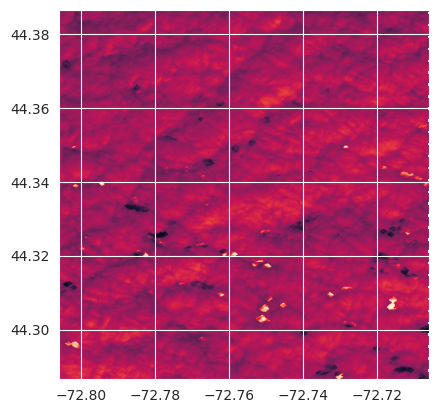

<Axes: >

In [ ]:
plot.show(r_dst)

In [ ]:
!cat output_file.vrt

<VRTDataset rasterXSize="10980" rasterYSize="10980">
  <SRS dataAxisToSRSAxisMapping="1,2">PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]</SRS>
  <GeoTransform>  6.0000000000000000e+05,  1.0000000000000000e+01,  0.0000000000000000e+00,  5.0000400000000000e+06,  0.0000000000000000e+00, -1.0000000000000000e+01</GeoTransform>
  <VRTRasterBand dataType="UInt16" band="1">
    <NoDataValue>0</NoDataValue>
    <ColorInterp>Gray</ColorInterp>
    <Comp

['output_file.vrt', '/vsicurl/https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/XQ/2021/01/02/S2A_MSIL2A_20210102T154641_N0212_R011_T18TXQ_20210103T050814.SAFE/GRANULE/L2A_T18TXQ_A028894_20210102T154805/IMG_DATA/R10m/T18TXQ_20210102T154641_B02_10m.tif?st=2024-01-07T14%3A52%3A31Z&se=2024-01-08T15%3A37%3A31Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-01-08T14%3A10%3A36Z&ske=2024-01-15T14%3A10%3A36Z&sks=b&skv=2021-06-08&sig=0SVPG%2BNfkPw8XrJR%2B112Fk5nH1F2iuTEPJ%2B78Wh7wL8%3D']
output_file.vrt
(10980, 10980)
<class 'numpy.ndarray'>


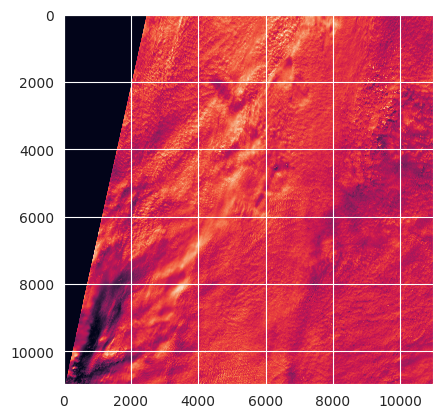

<Axes: >

In [ ]:
#Compare to original data
print(ds.GetFileList())
print(ds.GetDescription())
r_test = ds.ReadAsArray()
print(r_test.shape)
print(type(r_test))
plot.show(r_test)

In [ ]:
type(cat_search)

pystac_client.item_search.ItemSearch

In [ ]:
#arguments found at the beginning
#items_dict = [i.to_dict() for i in cat_search.get_items()]
#print(f"{len(items_dict)} scenes fetched")
selected_products2 = get_selected_products_and_bands(cat_search,
                                                     bands_selected,
                                                     platform=platform)


print(selected_products2.shape)
selected_products2.dtypes

/usr/local/lib/python3.10/dist-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


382 scenes fetched
datetime64[ns, UTC]
(382, 18)


properties.datetime        datetime64[ns, UTC]
assets.B02.href                         object
assets.B03.href                         object
assets.B04.href                         object
assets.B05.href                         object
assets.B06.href                         object
assets.B07.href                         object
assets.B08.href                         object
assets.B09.href                         object
assets.B11.href                         object
assets.B12.href                         object
assets.B8A.href                         object
assets.SCL.href                         object
collection                              object
id                                      object
properties.s2:mgrs_tile                 object
properties.proj:epsg                     int64
date                                    object
dtype: object

We show an example of asset band URL that can be used to process and download the data below. Note again that the url includes the file path, file name and token to access the data on Microsoft Planetary Computer.

In [ ]:
raster_file_list_test = selected_products2.loc[selected_products2['date']==val_start_date,'assets.B05.href'].tolist()
print(type(raster_file_list_test))
raster_file_list_test

<class 'list'>


['https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/XQ/2021/01/02/S2A_MSIL2A_20210102T154641_N0212_R011_T18TXQ_20210103T050814.SAFE/GRANULE/L2A_T18TXQ_A028894_20210102T154805/IMG_DATA/R20m/T18TXQ_20210102T154641_B05_20m.tif?st=2024-01-07T14%3A52%3A31Z&se=2024-01-08T15%3A37%3A31Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-01-08T14%3A10%3A36Z&ske=2024-01-15T14%3A10%3A36Z&sks=b&skv=2021-06-08&sig=0SVPG%2BNfkPw8XrJR%2B112Fk5nH1F2iuTEPJ%2B78Wh7wL8%3D']

Let's use the new function we created to process a specific date. The parameters are as follow:

- date_val: date to process
- selected_products: data frame produced after filtering for the relevant products and containing the URL to access the asset as well as dates.
- download: if True, the raw STAC files are downloaded locally before processing otherwise, we use streaming.
- aoi_poly: reference AOI vector file or geodataframe
- output_epsg: if None, this will be infer from the the input AOI vector file.
- output_res: the output resolution for the new files
- output_dir: output directory path


Note that by default the processed images are placed in the following dir:
output_dir/collection/date/output_filename
where:

- out_dir = local path dir for the output
- collection = program missionwith platform name (e.g. Sentinel 2A)
- date
- outputfile name: by default the name is 'crop_proj'{collection}_assets.SCL

./sentinel-2-l2a/20210102/crop_proj_sentinel-2-l2a_assets.band_name.href_date.tif

e.g.:

./sentinel-2-l2a/20210102/crop_proj_sentinel-2-l2a_assets.SCL.href_20210102.tif

In [ ]:
#24 sec for 12 bands
print(output_res) #note that we may want to change this into different res for different band
output_file = download_and_reproject_stac_file(date_val=val_start_date,
                                 selected_products=selected_products2,
                                 download=False,
                                 aoi_poly=bbox_poly_gdf,
                                 output_epsg=None,
                                 output_res=output_res,
                                 out_dir='.')

output_file

0.00009
[32618]
[32618]
[32618]
[32618]
[32618]
[32618]
[32618]
[32618]
[32618]
[32618]
[32618]
[32618]


'./sentinel-2-l2a/20210102/crop_proj_sentinel-2-l2a_assets.SCL.href_20210102.tif'

The function we created will process all the bands in the geodataframe we provided and create new output names in an automated fashion. All new files will have the prefix
'crop_proj_' at the beginning fo the file name.

In [ ]:
val_start_date_formatted = val_start_date.replace('-',"")
data_path = f'./sentinel-2-l2a/{val_start_date_formatted}'
os.environ['DATA_PATH'] = data_path
!ls -ltr $DATA_PATH

total 44670
-rw------- 1 root root 2476798 Nov 29 01:35 masked_crop_proj_sentinel-2-l2a_assets.B03.href_20210102.tif
-rw------- 1 root root 2476799 Nov 29 01:39 masked_crop_proj_sentinel-2-l2a_assets.B04.href_20210102.tif
-rw------- 1 root root 2476798 Nov 29 01:42 masked_crop_proj_sentinel-2-l2a_assets.B08.href_20210102.tif
-rw------- 1 root root 4944333 Nov 29 01:45 ndvi_masked_20210102.tif
-rw------- 1 root root 4944333 Nov 29 01:47 ndwi_masked_20210102.tif
-rw------- 1 root root 2471246 Jan  8 14:52 crop_proj_sentinel-2-l2a_assets.B02.href_20210102.tif
-rw------- 1 root root 2471246 Jan  8 14:52 crop_proj_sentinel-2-l2a_assets.B03.href_20210102.tif
-rw------- 1 root root 2471246 Jan  8 14:52 crop_proj_sentinel-2-l2a_assets.B04.href_20210102.tif
-rw------- 1 root root 2471246 Jan  8 14:52 crop_proj_sentinel-2-l2a_assets.B05.href_20210102.tif
-rw------- 1 root root 2471246 Jan  8 14:53 crop_proj_sentinel-2-l2a_assets.B06.href_20210102.tif
-rw------- 1 root root 2471246 Jan  8 14:53 c

Let's visualize at the NIR image using the test file. We use rasterio to create a dataset connection, examine metadata and plot the data. The metada indicates:

- CRS is now 4326 so it was reprojected.
- resolution is 0.00009 (or equivalent to 10m)
- the image size is 1111x1111 with extent matching the input AOI.

./sentinel-2-l2a/20210102/crop_proj_sentinel-2-l2a_assets.B04.href_20210102.tif
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1111, 'height': 1111, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(9e-05, 0.0, -72.80588972127818,
       0.0, -9e-05, 44.38653872978746)}


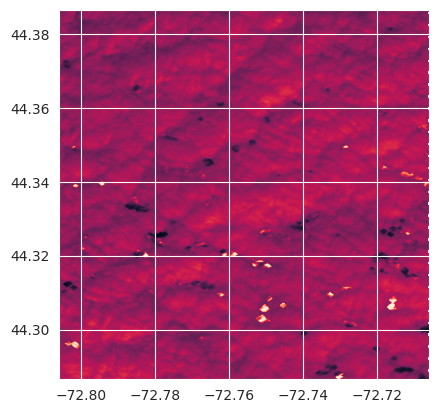

<Axes: >

In [ ]:
output_file_test = output_file.replace('SCL','B04')
print(output_file_test)
r_crop = rasterio.open(output_file_test)
print(r_crop.meta)
plot.show(r_crop)

#8.Conclusions

In this blog/exercise, we explored the impact of a major flooding event in Vermont using Sentinel 2, satellite imagery data. We showed how to download and process Sentinel 2 data for multiple dates (almost three years) using COGS and STAC framework.

The overall gaol was also to show how to leverage Sentinel 2 data once procesed. We used Sentinel2 data to assess the impact of flooding in multiple ways:

1. Visual impact with raw bands:

We compared the date before and after visually using raw bands from Sentinel 2.

- visual impact of flooding using true color composite (RGB)
- visual impact using NIR (band 08).

2. Visual impact with NDVI and NDWI indices

Raw spectral bands are useful but spectral indices made up of a combination of bands can help in highlitghting specific features on the ground surface.
We created the Normalized Difference Vegetation Index and the Normalized Difference Water Index to detect the impact of flooding on vegetation and water areas. We exepect NDVI values close to zero or negative for flooded areas and for NDWI values we expect hight values (above 0.5) for flooded areas.

3. Using time series profiles

We examined individual and average time sereis profile at dfferent location int the AOI and detected drop or rise at the time of the event for NDVI and NDWI respectively.


**Improvements**

We hope that this blog/exercise provided a complete example of workflow for the use of Sentinel 2 data with STAC and COGS. As expected, there are several improvements that could be made:

- thresholds results using NDVI or NDWI to map flooding event.
- use an algorithm/model map the area flooded.

#8.References


Obregón, M.A., Rodrigues, G., Costa, M.J., et al. (2019). Validation of ESA Sentinel-2 L2A aerosol optical thickness and columnar water vapour during 2017-2018. Remote Sensing, 11(14), 1649. https://doi.org/10.3390/rs11141649

Schläpfer, D., Borel, C.C., Keller, J., et al. (1998). Atmospheric precorrected differential absorption technique to retrieve columnar water vapor. Remote Sensing of Environment, 65(3), 353-366. https://doi.org/10.1016/S0034-4257(98)00044-3.

Gascon F., Bouzinac C., Thépaut O., et al. (2017). Copernicus Sentinel-2A calibration and products validation status. Remote Sensing, 9(6), 584. https://doi.org/10.3390/rs9060584


In [ ]:
############################# END OF SCRIPT ###################################